<h1 align=center><font size = 5>Notebook of Week 2 Assignment - Battle of Neighbourhoods</font></h1>


#### Question:

Can we find neigbourhoods in New York which are similar to Downtown Toronto?

## 1. collect data / EDA

#### Import lib

In [42]:
import numpy as np 
import pandas as pd


import json 
import requests 
from pandas.io.json import json_normalize
import lxml.html as lh

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import matplotlib.cm as cm
import matplotlib.colors as colors
import folium 

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler


In [47]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [26]:

CLIENT_ID = 'EJZLF0IMZUXJSA0GEVXDOYJ452TVHORAFRYYUDTH1WLQOQJR' # your Foursquare ID
CLIENT_SECRET = 'BU5SP25HABDZBJQDJI4IJJOGP0FIHSF1CDDZ2QHVAJBLRSF0' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
radius=500
LIMIT=100

#### def functions

In [27]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url_ = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url_).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [84]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[2:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#### collect data of New York

In [6]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
neighborhoods_data = newyork_data['features']
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
ny_geo = pd.DataFrame(columns=column_names)#neighborhoods
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    ny_geo = ny_geo.append({'Borough': borough,
                    'Neighborhood': neighborhood_name,
                    'Latitude': neighborhood_lat,
                    'Longitude': neighborhood_lon}, ignore_index=True)
ny_geo.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [25]:
manhattan_geo = ny_geo[ny_geo['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_geo.shape

(40, 4)

In [139]:
manhattan_geo.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


In [28]:
manhattan_venues = getNearbyVenues(names=manhattan_geo['Neighborhood'],
                                   latitudes=manhattan_geo['Latitude'],
                                   longitudes=manhattan_geo['Longitude']
                                  )
manhattan_venues.head()

Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.91066,Arturo's,40.874412,-73.910271,Pizza Place
1,Marble Hill,40.876551,-73.91066,Bikram Yoga,40.876844,-73.906204,Yoga Studio
2,Marble Hill,40.876551,-73.91066,Tibbett Diner,40.880404,-73.908937,Diner
3,Marble Hill,40.876551,-73.91066,Starbucks,40.877531,-73.905582,Coffee Shop
4,Marble Hill,40.876551,-73.91066,Dunkin',40.877136,-73.906666,Donut Shop


In [35]:
manhattan_venues.shape

(3104, 7)

In [82]:
ny_venues=manhattan_venues
# one hot encoding
ny_onehot = pd.get_dummies(ny_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
ny_onehot['Neighborhood'] = ny_venues['Neighborhood'] 
ny_onehot['Borough'] = 'Manhanttan'
# move neighborhood column to the first column
fixed_columns = [ny_onehot.columns[-1]] + list(ny_onehot.columns[:-1])
ny_onehot = ny_onehot[fixed_columns]

ny_grouped = ny_onehot.groupby(['Neighborhood','Borough']).mean().reset_index()
ny_grouped.head()

,Neighborhood,Borough,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Butcher,Cafeteria,Café,Cambodian Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Caucasian Restaurant,Cha Chaan Teng,Cheese Shop,Chinese Restaurant,Chocolate Shop,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,College Cafeteria,College Theater,Comedy Club,Comfort Food Restaurant,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Financial or Legal Service,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music School,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Physical Therapist,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Repair,Shoe Store,Shopping Ma

In [38]:
ny_grouped.shape

(40, 332)

#### collect data of Toronto

In [43]:
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M' 
page = requests.get(url)
doc = lh.fromstring(page.content)
#table = doc.xpath('//html/body/div[3]/div[3]/div[4]/div/table[1]')
tr=doc.xpath('//tr')
n=len(tr)
#remove last 4 rows
del tr[n-1]
del tr[n-2]
del tr[n-3]
del tr[n-4]
col=tr[0].text_content().split('\n\n')
col=[val.replace('\n', '') for val in col] 
del tr[0]
#rows = [r.replace('\n', '') for r in rows] 
tr[0].text_content().split('\n\n')

pcodes = pd.DataFrame (columns = col)
i=0
for r in tr:
    r=r.text_content().split('\n\n')
    r = [val.replace('\n', '') for val in r] 
    #print(r)
    pcodes.loc[i]=r
    i=i+1

pcodes=pcodes[pcodes['Borough']!='Not assigned']
pcodes.reset_index(inplace=True)
pcodes.drop(columns={'index'}, inplace=True)
geolist = pd.read_csv('https://cocl.us/Geospatial_data')

toronto_geo = pd.merge(pcodes,geolist,on='Postal Code')
toronto_geo.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [141]:
down_toronto_geo=toronto_geo[toronto_geo['Borough']=='Downtown Toronto']
down_toronto_geo.drop('Postal Code', axis=1).head()

,Borough,Neighborhood,Latitude,Longitude
2,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
4,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
9,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
15,Downtown Toronto,St. James Town,43.651494,-79.375418
20,Downtown Toronto,Berczy Park,43.644771,-79.373306


In [57]:
toronto_venues = getNearbyVenues(names=down_toronto_geo['Neighborhood'],
                                   latitudes=down_toronto_geo['Latitude'],
                                   longitudes=down_toronto_geo['Longitude']
                                  )
toronto_venues.head()

Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Harbourfront East, Union Station, Toronto Islands
Toronto Dominion Centre, Design Exchange
Commerce Court, Victoria Hotel
University of Toronto, Harbord
Kensington Market, Chinatown, Grange Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Rosedale
Stn A PO Boxes
St. James Town, Cabbagetown
First Canadian Place, Underground city
Church and Wellesley


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park, Harbourfront",43.65426,-79.360636,Morning Glory Cafe,43.653947,-79.361149,Breakfast Spot
3,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
4,"Regent Park, Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa


In [138]:
down_toronto_venues=toronto_venues
down_toronto_venues.shape

(1222, 7)

In [81]:
# one hot encoding
toronto_onehot = pd.get_dummies(down_toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = down_toronto_venues['Neighborhood'] 
toronto_onehot['Borough'] = 'Downtown Toronto'

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_grouped = toronto_onehot.groupby(['Neighborhood','Borough']).mean().reset_index()
toronto_grouped.head()

,Neighborhood,Borough,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Butcher,Cable Car,Café,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Convention Center,Cosmetics Shop,Creperie,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Berczy Park,Downtown Toronto,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.017857,0.000000,0.000000,0.0,0.017857,0.000000,0.017857,0.035714,0.000000,0.000000,0.0,0.017857,0.017857,0.0,0.035714,0.0,0.0,0.017857,0.000000,0.000000,0.000000,0.0,0.017857,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.035714,0.0,0.000000,0.000000,0.035714,0.000000,0.0,0.0,0.017857,0.053571,0.071429,0.0,0.0,0.0,0.0,0.0,0.0,0.017857,0.000000,0.017857,0.0,0.0,0.0,0.017857,0.0,0.000000,0.0,0.000000,0.000000,0.017857,0.000000,0.000000,0.000000,0.0,0.000000,0.017857,0.0,0.000000,0.0,0.000000,0.017857,0.000000,0.0,0.017857,0.000000,0.000000,0.0,0.0,0.017857,0.017857,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.017857,0.017857,0.017857,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.017857,0.0,0.0,0.000000,0.000000,0.0,0.017857,0.000000,0.017857,0.017857,0.0,0.000000,0.000000,0.0,0.0,0.0,0.017857,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0000

In [60]:
toronto_grouped.shape

(19, 213)

#### combine data sets

In [63]:

two_cities_grouped= vertical_stack = pd.concat([ny_grouped.set_index('Neighborhood'), toronto_grouped.set_index('Neighborhood')], axis=0) 
two_cities_grouped

,Borough,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Butcher,Cafeteria,Café,Cambodian Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Caucasian Restaurant,Cha Chaan Teng,Cheese Shop,Chinese Restaurant,Chocolate Shop,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,College Cafeteria,College Theater,Comedy Club,Comfort Food Restaurant,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Financial or Legal Service,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music School,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Physical Therapist,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Repair,Shoe Store,Shopping Mall,Skate Park

In [64]:
two_cities_grouped.shape

(59, 365)

In [73]:
two_cities_grouped=two_cities_grouped.fillna(0)
two_cities_grouped.isna().any()

Borough                                     False
Accessories Store                           False
Adult Boutique                              False
Afghan Restaurant                           False
African Restaurant                          False
American Restaurant                         False
Antique Shop                                False
Arcade                                      False
Arepa Restaurant                            False
Argentinian Restaurant                      False
Art Gallery                                 False
Art Museum                                  False
Arts & Crafts Store                         False
Asian Restaurant                            False
Athletics & Sports                          False
Auditorium                                  False
Australian Restaurant                       False
Austrian Restaurant                         False
BBQ Joint                                   False
Baby Store                                  False


In [142]:
two_cities_grouped.head()

,Borough,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Butcher,Cafeteria,Café,Cambodian Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Caucasian Restaurant,Cha Chaan Teng,Cheese Shop,Chinese Restaurant,Chocolate Shop,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,College Cafeteria,College Theater,Comedy Club,Comfort Food Restaurant,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Financial or Legal Service,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music School,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Physical Therapist,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Repair,Shoe Store,Shopping Mall,Skate Park

In [112]:


num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood', 'Borough']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe with most common venues #neighborhoods_venues_sorted
two_cities_common_venues = pd.DataFrame(columns=columns)
two_cities_common_venues[['Neighborhood','Borough']] = two_cities_grouped.reset_index()[['Neighborhood','Borough']]
#two_cities_common_venues['Borough'] = two_cities_grouped['Borough']

for ind in np.arange(two_cities_grouped.shape[0]):
    two_cities_common_venues.iloc[ind, 2:] = return_most_common_venues(two_cities_grouped.iloc[ind, :], num_top_venues)
# for ind in np.arange(toronto_grouped.shape[0]):
#     two_cities_common_venues.iloc[two_cities_grouped.shape[0]+ind, 2:] = return_most_common_venues(two_cities_grouped.iloc[ind, :], num_top_venues)

two_cities_common_venues.head()

,Neighborhood,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Battery Park City,Manhanttan,Park,Hotel,Coffee Shop,Gym,Memorial Site,Boat or Ferry,Beer Garden,Food Court,Playground,Plaza
1,Carnegie Hill,Manhanttan,Coffee Shop,Pizza Place,Café,Yoga Studio,Wine Shop,Gym,Bookstore,Japanese Restaurant,Supermarket,Italian Restaurant
2,Central Harlem,Manhanttan,Chinese Restaurant,African Restaurant,Bar,American Restaurant,Cosmetics Shop,Seafood Restaurant,French Restaurant,Dessert Shop,Gym / Fitness Center,Beer Bar
3,Chelsea,Manhanttan,Art Gallery,Coffee Shop,Café,Ice Cream Shop,American Restaurant,Bakery,Italian Restaurant,Market,Park,Cupcake Shop
4,Chinatown,Manhanttan,Chinese Restaurant,Bakery,Bubble Tea Shop,Cocktail Bar,Spa,Vietnamese Restaurant,American Restaurant,Optical Shop,Ice Cream Shop,Coffee Shop


In [97]:
two_cities_common_venues.shape

(59, 12)

In [113]:
two_cities_common_venues.tail()

,Neighborhood,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
54,St. James Town,Downtown Toronto,Café,Coffee Shop,Restaurant,Cocktail Bar,American Restaurant,Gastropub,Lingerie Store,Creperie,Gym,Theater
55,"St. James Town, Cabbagetown",Downtown Toronto,Coffee Shop,Chinese Restaurant,Bakery,Restaurant,Café,Pub,Pizza Place,Italian Restaurant,Thai Restaurant,Park
56,Stn A PO Boxes,Downtown Toronto,Coffee Shop,Café,Restaurant,Italian Restaurant,Cocktail Bar,Seafood Restaurant,Beer Bar,Pub,Japanese Restaurant,Breakfast Spot
57,"Toronto Dominion Centre, Design Exchange",Downtown Toronto,Coffee Shop,Café,Hotel,Restaurant,Italian Restaurant,American Restaurant,Japanese Restaurant,Seafood Restaurant,Salad Place,Sporting Goods Shop
58,"University of Toronto, Harbord",Downtown Toronto,Café,Restaurant,Bar,Bookstore,Japanese Restaurant,Bakery,Italian Restaurant,Dessert Shop,Pub,Beer Bar


## 2. build Cluster

#### find k?

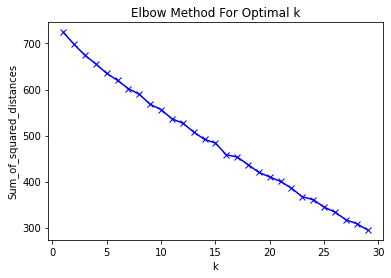

In [124]:
import matplotlib.pyplot as plt
mms = MinMaxScaler()
data=two_cities_grouped.drop(columns=['Borough'], axis=1)
mms.fit(data)
data_transformed = mms.transform(data)
Sum_of_squared_distances = []
K = range(1,30)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(data_transformed)
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

#### build cluster

In [153]:
# set number of clusters
kclusters = 8

df_clustering = two_cities_grouped.drop('Borough', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 0, 3, 4, 3, 4, 3, 3, 3, 0], dtype=int32)

In [154]:
#final = toronto_merged[toronto_merged['Cluster Labels']==1].drop('Cluster Labels', axis=1)
final=two_cities_common_venues.drop('Cluster Labels', axis=1)
final.insert(0, 'Cluster Labels', kmeans.labels_)

## 3. Result data set

In [155]:
final.head()

,Cluster Labels,Neighborhood,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,Battery Park City,Manhanttan,Park,Hotel,Coffee Shop,Gym,Memorial Site,Boat or Ferry,Beer Garden,Food Court,Playground,Plaza
1,0,Carnegie Hill,Manhanttan,Coffee Shop,Pizza Place,Café,Yoga Studio,Wine Shop,Gym,Bookstore,Japanese Restaurant,Supermarket,Italian Restaurant
2,3,Central Harlem,Manhanttan,Chinese Restaurant,African Restaurant,Bar,American Restaurant,Cosmetics Shop,Seafood Restaurant,French Restaurant,Dessert Shop,Gym / Fitness Center,Beer Bar
3,4,Chelsea,Manhanttan,Art Gallery,Coffee Shop,Café,Ice Cream Shop,American Restaurant,Bakery,Italian Restaurant,Market,Park,Cupcake Shop
4,3,Chinatown,Manhanttan,Chinese Restaurant,Bakery,Bubble Tea Shop,Cocktail Bar,Spa,Vietnamese Restaurant,American Restaurant,Optical Shop,Ice Cream Shop,Coffee Shop


In [156]:
final.groupby('Cluster Labels').count()

,Neighborhood,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Cluster Labels,,,,,,,,,,,,
0,7,7,7,7,7,7,7,7,7,7,7,7
1,2,2,2,2,2,2,2,2,2,2,2,2
2,1,1,1,1,1,1,1,1,1,1,1,1
3,27,27,27,27,27,27,27,27,27,27,27,27
4,19,19,19,19,19,19,19,19,19,19,19,19
5,1,1,1,1,1,1,1,1,1,1,1,1
6,1,1,1,1,1,1,1,1,1,1,1,1
7,1,1,1,1,1,1,1,1,1,1,1,1


In [157]:
final[final['Cluster Labels'] == 0]

,Cluster Labels,Neighborhood,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,0,Carnegie Hill,Manhanttan,Coffee Shop,Pizza Place,Café,Yoga Studio,Wine Shop,Gym,Bookstore,Japanese Restaurant,Supermarket,Italian Restaurant
9,0,Financial District,Manhanttan,Coffee Shop,American Restaurant,Pizza Place,Café,Hotel,Gym,Cocktail Bar,Steakhouse,Sandwich Place,Event Space
13,0,Hamilton Heights,Manhanttan,Pizza Place,Coffee Shop,Deli / Bodega,Café,Mexican Restaurant,Sandwich Place,School,Bakery,Chinese Restaurant,Yoga Studio
20,0,Manhattan Valley,Manhanttan,Coffee Shop,Mexican Restaurant,Bar,Yoga Studio,Pizza Place,Health Food Store,Spa,Bike Shop,Chinese Restaurant,Playground
25,0,Morningside Heights,Manhanttan,Park,American Restaurant,Bookstore,Coffee Shop,Burger Joint,Deli / Bodega,Sandwich Place,College Cafeteria,New American Restaurant,Pizza Place
27,0,Noho,Manhanttan,Coffee Shop,Pizza Place,Italian Restaurant,Sandwich Place,Grocery Store,Japanese Restaurant,Wine Shop,Mexican Restaurant,Pet Store,French Restaurant
49,0,"Kensington Market, Chinatown, Grange Park",Downtown Toronto,Café,Coffee Shop,Mexican Restaurant,Vegetarian / Vegan Restaurant,Bakery,Vietnamese Restaurant,Grocery Store,Bar,Park,Gaming Cafe


In [161]:
final[final['Cluster Labels'] == 1]

,Cluster Labels,Neighborhood,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,Battery Park City,Manhanttan,Park,Hotel,Coffee Shop,Gym,Memorial Site,Boat or Ferry,Beer Garden,Food Court,Playground,Plaza
28,1,Roosevelt Island,Manhanttan,Park,School,Waterfront,Metro Station,Farmers Market,Residential Building (Apartment / Condo),Bubble Tea Shop,Greek Restaurant,Noodle House,Supermarket


In [159]:
final[final['Cluster Labels'] == 3]

,Cluster Labels,Neighborhood,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,3,Central Harlem,Manhanttan,Chinese Restaurant,African Restaurant,Bar,American Restaurant,Cosmetics Shop,Seafood Restaurant,French Restaurant,Dessert Shop,Gym / Fitness Center,Beer Bar
4,3,Chinatown,Manhanttan,Chinese Restaurant,Bakery,Bubble Tea Shop,Cocktail Bar,Spa,Vietnamese Restaurant,American Restaurant,Optical Shop,Ice Cream Shop,Coffee Shop
6,3,Clinton,Manhanttan,Theater,Gym / Fitness Center,Coffee Shop,Italian Restaurant,Spa,Gym,American Restaurant,Thai Restaurant,Hotel,Pizza Place
7,3,East Harlem,Manhanttan,Mexican Restaurant,Bakery,Thai Restaurant,Latin American Restaurant,Deli / Bodega,Cuban Restaurant,Spa,Burger Joint,Beer Bar,Convenience Store
8,3,East Village,Manhanttan,Cocktail Bar,Mexican Restaurant,Bar,Pizza Place,Coffee Shop,Japanese Restaurant,Ice Cream Shop,Wine Bar,Ramen Restaurant,Juice Bar
10,3,Flatiron,Manhanttan,Gym / Fitness Center,Café,Italian Restaurant,Spa,Toy / Game Store,Park,Mediterranean Restaurant,Yoga Studio,Coffee Shop,Japanese Restaurant
11,3,Gramercy,Manhanttan,Bagel Shop,Coffee Shop,Pizza Place,Bar,Mexican Restaurant,Grocery Store,Playground,Cocktail Bar,American Restaurant,Italian Restaurant
12,3,Greenwich Village,Manhanttan,Italian Restaurant,Café,Sushi Restaurant,Pizza Place,Gym,Burger Joint,Dessert Shop,Pilates Studio,Vietnamese Restaurant,Bar
14,3,Hudson Yards,Manhanttan,Italian Restaurant,Gym / Fitness Center,Hotel,American Restaurant,Coffee Shop,Dog Run,Restaurant,Gym,Café,Park
15,3,Inwood,Manhanttan,Mexican Restaurant,Restaurant,Café,Lounge,Chinese Restaurant,Pizza Place,Bakery,Wine Bar,Deli / Bodega,Spanish Restaurant


In [160]:
final[final['Cluster Labels'] == 4]

,Cluster Labels,Neighborhood,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,4,Chelsea,Manhanttan,Art Gallery,Coffee Shop,Café,Ice Cream Shop,American Restaurant,Bakery,Italian Restaurant,Market,Park,Cupcake Shop
5,4,Civic Center,Manhanttan,Coffee Shop,French Restaurant,Hotel,Cocktail Bar,American Restaurant,Spa,Park,Gym / Fitness Center,Café,Bakery
21,4,Manhattanville,Manhanttan,Coffee Shop,Seafood Restaurant,Chinese Restaurant,Deli / Bodega,Mexican Restaurant,Park,Italian Restaurant,Diner,Boutique,Bus Station
22,4,Marble Hill,Manhanttan,Sandwich Place,Coffee Shop,Gym,Shopping Mall,Yoga Studio,Video Game Store,Tennis Stadium,Pharmacy,Pizza Place,Supplement Shop
23,4,Midtown,Manhanttan,Coffee Shop,Hotel,Theater,Bakery,Pizza Place,Clothing Store,Sushi Restaurant,Cuban Restaurant,Japanese Restaurant,American Restaurant
24,4,Midtown South,Manhanttan,Korean Restaurant,Hotel,Dessert Shop,Japanese Restaurant,American Restaurant,Coffee Shop,Burger Joint,Café,Hotel Bar,Gym / Fitness Center
40,4,Berczy Park,Downtown Toronto,Coffee Shop,Cocktail Bar,Seafood Restaurant,Beer Bar,Restaurant,Cheese Shop,Bakery,Pub,Café,Sporting Goods Shop
42,4,Central Bay Street,Downtown Toronto,Coffee Shop,Café,Italian Restaurant,Sandwich Place,Japanese Restaurant,Bubble Tea Shop,Chinese Restaurant,Department Store,Burger Joint,Salad Place
44,4,Church and Wellesley,Downtown Toronto,Coffee Shop,Sushi Restaurant,Japanese Restaurant,Restaurant,Gay Bar,Burger Joint,Café,Yoga Studio,Men's Store,Mediterranean Restaurant
45,4,"Commerce Court, Victoria Hotel",Downtown Toronto,Coffee Shop,Restaurant,Café,Hotel,American Restaurant,Gym,Seafood Restaurant,Deli / Bodega,Italian Restaurant,Japanese Restaurant


In [162]:
final[final['Cluster Labels'] == 4].shape

(19, 13)